# Pre-Training a Large Language Model: Self-Supervised Learning

A toy example based on https://huggingface.co/learn/llm-course/en/chapter7/6

## Download Data

In [1]:
from datasets import load_dataset, DatasetDict

ds_train = load_dataset("huggingface-course/codeparrot-ds-train", split="train[:100]")
ds_valid = load_dataset("huggingface-course/codeparrot-ds-valid", split="validation[:100]")

raw_datasets = DatasetDict(
    {
        "train": ds_train,  # .shuffle().select(range(50000)),
        "valid": ds_valid,  # .shuffle().select(range(500))
    }
)

raw_datasets

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


codeparrot-ds-train.jsonl:   0%|          | 0.00/8.25G [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

codeparrot-ds-valid.jsonl:   0%|          | 0.00/46.1M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/3322 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['repo_name', 'path', 'copies', 'size', 'content', 'license'],
        num_rows: 100
    })
    valid: Dataset({
        features: ['repo_name', 'path', 'copies', 'size', 'content', 'license'],
        num_rows: 100
    })
})

In [6]:
for key in raw_datasets["train"][0]:
    print(f"{key.upper()}: {raw_datasets['train'][0][key][:200]}")

REPO_NAME: kmike/scikit-learn
PATH: sklearn/utils/__init__.py
COPIES: 3
SIZE: 10094
CONTENT: """
The :mod:`sklearn.utils` module includes various utilites.
"""

from collections import Sequence

import numpy as np
from scipy.sparse import issparse
import warnings

from .murmurhash import murm
LICENSE: bsd-3-clause


## Tokenize the data

In [2]:
from transformers import AutoTokenizer

context_length = 128
tokenizer = AutoTokenizer.from_pretrained("huggingface-course/code-search-net-tokenizer")

outputs = tokenizer(
    raw_datasets["train"][:2]["content"],
    truncation=True,
    max_length=context_length,
    return_overflowing_tokens=True,
    return_length=True,
)

print(f"Input IDs length: {len(outputs['input_ids'])}")
print(f"Input chunk lengths: {(outputs['length'])}")
print(f"Chunk mapping: {outputs['overflow_to_sample_mapping']}")

tokenizer_config.json:   0%|          | 0.00/265 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

Input IDs length: 34
Input chunk lengths: [128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 117, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 41]
Chunk mapping: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [5]:
outputs['input_ids'][0][:10]

[280, 173, 2096, 310, 2025, 749, 24661, 14, 1377, 64]

In [7]:
def tokenize(element):
    outputs = tokenizer(
        element["content"],
        truncation=True,
        max_length=context_length,
        return_overflowing_tokens=True,
        return_length=True,
    )
    input_batch = []
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        if length == context_length:
            input_batch.append(input_ids)
    return {"input_ids": input_batch}


tokenized_datasets = raw_datasets.map(
    tokenize, batched=True, remove_columns=raw_datasets["train"].column_names
)
tokenized_datasets

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids'],
        num_rows: 2483
    })
    valid: Dataset({
        features: ['input_ids'],
        num_rows: 2303
    })
})

## Initialize Model

In [10]:
len(tokenizer)

50000

In [8]:
from transformers import AutoTokenizer, GPT2LMHeadModel, AutoConfig

config = AutoConfig.from_pretrained(
    "gpt2",
    vocab_size=len(tokenizer),
    n_ctx=context_length,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [9]:
model = GPT2LMHeadModel(config)
model_size = sum(t.numel() for t in model.parameters())
print(f"GPT-2 size: {model_size/1000**2:.1f}M parameters")

GPT-2 size: 124.2M parameters


## Prepare Data Batches

In [11]:
from transformers import DataCollatorForLanguageModeling

tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

In [12]:
out = data_collator([tokenized_datasets["train"][i] for i in range(5)])
for key in out:
    print(f"{key} shape: {out[key].shape}")

input_ids shape: torch.Size([5, 128])
attention_mask shape: torch.Size([5, 128])
labels shape: torch.Size([5, 128])


## Training

In [21]:
from dotenv import load_dotenv
import os
load_dotenv(".env")
from huggingface_hub import login

login(token=os.getenv("HUGGINGFACE_TOKEN"))

Total steps = (num_train_epochs * dataset_size) / (per_device_train_batch_size * gradient_accumulation_steps)

In [52]:
from transformers import Trainer, TrainingArguments

os.environ["WANDB_DISABLED"] = "True"

args = TrainingArguments(
    output_dir="codeparrot-ds",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="steps", # Enable evaluation during training
    eval_steps=10,  # Evaluate every 10 steps
    logging_steps=10, # Log every 10 steps
    gradient_accumulation_steps=2,
    num_train_epochs=1,
    weight_decay=0.1,
    warmup_steps=1_000,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    save_steps=1_000,
    fp16=True,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer, # Use tokenizer instead of processing_class
    args=args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["valid"],
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-3442500269.py:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [53]:
trainer.train()

Step,Training Loss,Validation Loss
10,7.433800,7.837201
20,7.213100,7.777462
30,7.079900,7.699420
40,7.114300,7.580887
50,6.910500,7.440890
60,6.648300,7.305023
70,6.636600,7.175885


TrainOutput(global_step=78, training_loss=6.9443278679480915, metrics={'train_runtime': 128.3556, 'train_samples_per_second': 19.345, 'train_steps_per_second': 0.608, 'total_flos': 162197028864000.0, 'train_loss': 6.9443278679480915, 'epoch': 1.0})

In [32]:
trainer.push_to_hub()

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...rrot-ds/training_args.bin: 100%|##########| 5.78kB / 5.78kB            

  ...595072.8685af5425cb.323.0: 100%|##########| 10.7kB / 10.7kB            

  ...595390.8685af5425cb.323.1: 100%|##########| 5.58kB / 5.58kB            

  ...rrot-ds/model.safetensors:   7%|6         | 33.5MB /  497MB            

CommitInfo(commit_url='https://huggingface.co/ruben-balbastre-alcocer/codeparrot-ds/commit/e37c1440ae0374662a4b4503f674a8cdd8fc96d7', commit_message='End of training', commit_description='', oid='e37c1440ae0374662a4b4503f674a8cdd8fc96d7', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ruben-balbastre-alcocer/codeparrot-ds', endpoint='https://huggingface.co', repo_type='model', repo_id='ruben-balbastre-alcocer/codeparrot-ds'), pr_revision=None, pr_num=None)

## Metrics

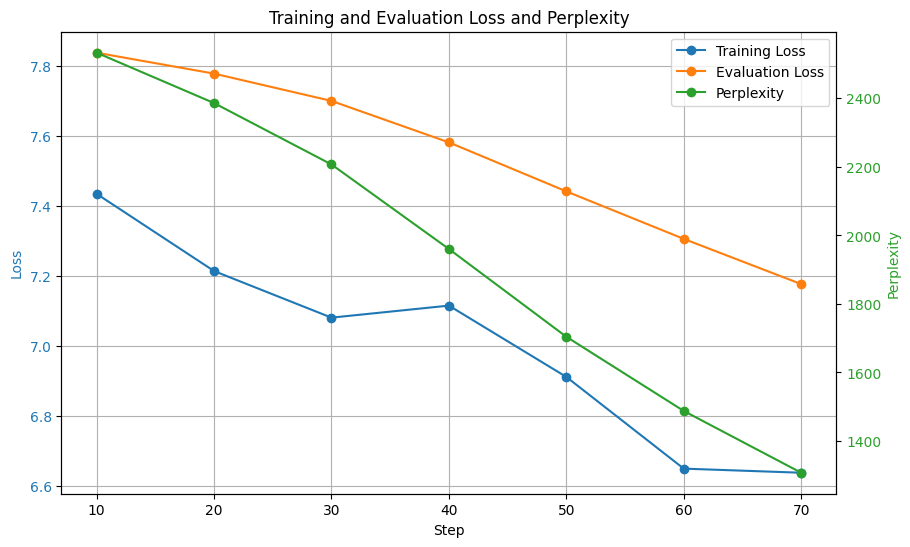

In [54]:
import json
import matplotlib.pyplot as plt
import math

logs = json.load(open("/content/codeparrot-ds/checkpoint-78/trainer_state.json", "r"))

losses = [entry["loss"] for entry in logs["log_history"] if "loss" in entry]
eval_losses = [entry["eval_loss"] for entry in logs["log_history"] if "eval_loss" in entry]
steps = [entry["step"] for entry in logs["log_history"] if "loss" in entry]
eval_steps = [entry["step"] for entry in logs["log_history"] if "eval_loss" in entry]


fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(steps, losses,"-o", label="Training Loss", color='tab:blue')
ax1.plot(eval_steps, eval_losses,"-o", label="Evaluation Loss", color='tab:orange')
ax1.set_xlabel("Step")
ax1.set_ylabel("Loss", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_title("Training and Evaluation Loss and Perplexity")
ax1.grid(True)


# Calculate and plot perplexity on a secondary y-axis
if eval_losses:
    perplexity = [math.exp(loss) for loss in eval_losses]
    ax2 = ax1.twinx()  # Create a second axes that shares the same x-axis
    ax2.plot(eval_steps, perplexity, "-o", label="Perplexity", color='tab:green')
    ax2.set_ylabel("Perplexity", color='tab:green')
    ax2.tick_params(axis='y', labelcolor='tab:green')

fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.show()